# **Dasar Analitik Data - Week 7**

### **Tugas - 3: Melakukan Proses Wrapper, Regularization, dan PCA**


**Nama: Aisyah Arifatul Alya** \
**NPM: 2206059383**

Sumber dataset yang digunakan pada tugas ini dapat diakses pada link berikut:
[Valorant Champions 2025 Paris -player & match data](https://www.kaggle.com/datasets/piyush86kumar/valorant-champions-tour-2025-paris?select=player_stats.csv)

In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression, LassoCV
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
url = 'https://raw.githubusercontent.com/arifatalya/Dataset-DAD/refs/heads/main/player_stats.csv'
df = pd.read_csv(url)
df.head(11)

,player,player_name,team,player_id,agents,agents_count,rounds,rating,acs,kd_ratio,...,fdpr,hs_percent,cl_percent,clutches,k_max,kills,deaths,assists,first_kills,first_deaths
0,aspas,aspas,MIBR,8480,"['Neon', 'Waylay', 'Raze', 'Jett']",4,330,1.33,261.6,1.66,...,0.07,26%,8%,2/26,32,319,192,44,67,23
1,RieNs,RieNs,TH,10971,"['Fade', 'Sova']",2,256,1.17,226.1,1.14,...,0.05,34%,20%,7/35,23,203,178,85,18,12
2,brawk,brawk,NRG,2172,"['Sova', 'Vyse']",2,377,1.16,224.6,1.17,...,0.06,17%,9%,4/47,28,275,236,128,26,23
3,kaajak,kaajak,FNC,9554,"['Yoru', 'Waylay', 'Raze', 'Neon']",4,453,1.15,227.1,1.20,...,0.13,32%,11%,3/28,30,372,311,90,95,59
4,johnqt,johnqt,SEN,1265,"['Viper', 'Cypher', 'Sova']",3,126,1.14,187.0,1.13,...,0.04,33%,9%,2/22,17,85,75,34,5,5
5,Smoggy,Smoggy,EDG,4742,"['Omen', 'Brimstone']",2,119,1.13,206.0,1.09,...,0.04,25%,17%,4/23,26,88,81,48,11,5
6,leaf,leaf,G2,7873,"['Cypher', 'Viper', 'Deadlock', 'Chamber']",4,268,1.11,222.8,1.13,...,0.09,21%,15%,5/33,30,213,188,69,30,24
7,something,something,PRX,17086,"['Yoru', 'Sova']",2,356,1.10,220.4,1.17,...,0.13,25%,13%,5/38,28,281,240,94,57,48
8,Knight,Knight,BLG,4774,"['Sova', 'Fade']",2,95,1.10,196.8,0.97,...,0.09,26%,12%,2/17,20,65,67,27,8,9
9,skuba,skuba,NRG,11118,"['Vyse', 'Viper', 'Killjoy', 'Cypher']",4,377,1.09,190.1,1.17,...,0.06,30%,21%,12/58,28,266,228,94,21,24


- Memilih hanya kolom-kolom numerik (exclude `player` dan `agent`) agar pemodelan tidak terganggu.

In [100]:
df_numeric = df.select_dtypes(include=['float64', 'int64']).dropna()

- Memilih `rating` sebagai target dan membagi dataset menjadi 80% train dan 20% test untuk validasi.

In [101]:
target = "rating"
X = df_numeric.drop(columns=[target])
y = df_numeric[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Melakukan *feature scaling* dengan standarisasi (mean = 0, standar deviasi = 1).

In [102]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

### **1. Wrapper: RFE (Recursive Feature Elimination) dengan Regresi Linear**

- Menggunakan model Regresi Linear untuk mengukur relevansi atau kontribusi fitur yang ada dengan fitur target (rating).
- RFE akan menghapus fitur dengan kontribusi terlemah, sehingga yang tersisa hanyalah yang terbaik.

In [111]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X_scaled, y_train)

selected_features = X.columns[rfe.support_]
print("Features Selected by RFE:")
print(selected_features)

Features Selected by RFE:
Index(['acs', 'kd_ratio', 'kpr', 'kills', 'deaths'], dtype='object')


Hasil metode Wrapper dengan RFE menunjukkan bahwa fitur-fitur yang paling berpengaruh dengan fitur `rating` adalah:
- `acs` (Average Combat Score)
- `adr` (Average Damage per Round)
- `kills`
- `fdpr` (First Death per Round)
- `deaths`

Berdasarkan hasil yang diperoleh, dapat disimpulkan bahwa performa dari para pemain (rating) tidak hanya ditentukan dari seberapa offensive mereka saat bertanding, namun juga seberapa jarang mereka terkena first pick oleh lawan (FDPR) dan tentunya KDA mereka.

In [112]:
ranking = pd.DataFrame({
    'Feature': X.columns,
    'Rank': rfe.ranking_
}).sort_values(by='Rank')

rfe_table = ranking.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#FFFFFF'), ('font-weight', 'bold'), ('color', 'black')]}]
)
display(rfe_table)

,Feature,Rank
3,acs,1
4,kd_ratio,1
6,kpr,1
11,kills,1
12,deaths,1
5,adr,2
9,fdpr,3
13,assists,4
14,first_kills,5
8,fkpr,6


### **2. Regularization: Lasso (L1) dan Ridge (L2)**

**A. Lasso**

- Menentukan nilai alpha yang optimal untuk menghindari penghapusan fitur yang berlebihan akibat penalti L1, di mana koefisien menjadi bernilai nol.

In [113]:
lasso = LassoCV(alphas=np.logspace(-3, 0, 50), cv=5)
lasso.fit(X_scaled, y_train)
print("Optimal alpha:", lasso.alpha_)

Optimal alpha: 0.0026826957952797246


In [114]:
lasso = Lasso(alpha=0.0026826957952797246)
lasso.fit(X_scaled, y_train)

lasso_coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
})

lasso_table = lasso_coefs.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#FFFFFF'), ('font-weight', 'bold'), ('color', 'black')]}]
)
display(lasso_table)

,Feature,Coefficient
0,player_id,-0.000194
1,agents_count,-0.000402
2,rounds,0.000000
3,acs,0.005155
4,kd_ratio,0.073135
5,adr,0.032516
6,kpr,0.000000
7,apr,0.011297
8,fkpr,-0.000000
9,fdpr,-0.019291


**B. Ridge**

- Tidak ada fitur yang dieliminasi seperti pada Lasso, namun fitur dengan bobot yang kecil nilainya juga menurun.

In [115]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_scaled, y_train)

ridge_coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge.coef_
})

ridge_table = ridge_coefs.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#FFFFFF'), ('font-weight', 'bold'), ('color', 'black')]}]
)
display(ridge_table)

,Feature,Coefficient
0,player_id,-0.002582
1,agents_count,-0.001457
2,rounds,0.013121
3,acs,0.025953
4,kd_ratio,0.072651
5,adr,0.034231
6,kpr,-0.006795
7,apr,0.004048
8,fkpr,-0.007853
9,fdpr,-0.026045


Berdasarkan hasil visualisasi dengan bar plot, fitur yang memiliki bobot tertinggi terhadap peningkatan nilai rating pemain adalah `acs`, `kills`, dan `kd_ratio`.
Di sisi lain, `fdpr` dan `deaths` memiliki bobot sedang dengan arah negatif, menandakan bahwa semakin sering pemain mati lebih dahulu di ronde atau memiliki tingkat kematian tinggi, semakin rendah pula rating yang diperoleh.

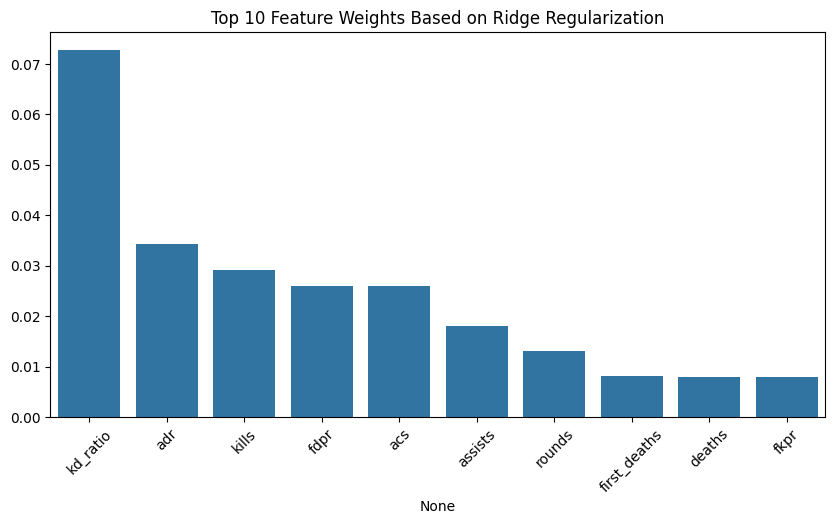

In [116]:
ridge_coefs_bar = pd.Series(ridge.coef_, index=X.columns)

plt.figure(figsize=(10,5))
sns.barplot(x=ridge_coefs_bar.abs().sort_values(ascending=False).index[:10],
            y=ridge_coefs_bar.abs().sort_values(ascending=False).values[:10])
plt.title("Top 10 Feature Weights Based on Ridge Regularization")
plt.xticks(rotation=45)
plt.show()


### **3. Principal Component Analysis (PCA) dengan Dua Komponen**

In [117]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", sum(pca.explained_variance_ratio_))


Explained variance ratio: [0.42601563 0.25111002]
Total variance explained: 0.6771256425231049


- Komponen utama pertama (PC1) menjelaskan 42,6% dari total variasi yang ada dalam seluruh fitur numerik.
- Komponen utama kedua (PC2) menjelaskan 25,1% variasi.

Maka dari itu, total variance yang dijelaskan oleh dua komponen utama mencapai 67,7% dan PCA berhasil melakukan reduksi dimensi tanpa kehilangan banyak informasi.

In [118]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=X.columns
)

loadings_table = loadings.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#FFFFFF'), ('font-weight', 'bold'), ('color', 'black')]}]
)
display(loadings_table)


,PC1,PC2
player_id,-0.018066,-0.199496
agents_count,0.034156,0.055473
rounds,0.256454,0.358601
acs,0.301560,-0.250060
kd_ratio,0.313692,-0.104259
adr,0.282696,-0.266452
kpr,0.307389,-0.258365
apr,-0.107215,0.304751
fkpr,0.236373,-0.267861
fdpr,0.117125,-0.192384


#### **Summary dari semua metode yang dilakukan:**

In [119]:
summary = pd.DataFrame({
    'Feature': X.columns,
    'RFE_Selected': rfe.support_,
    'Lasso_Coeff': lasso.coef_,
    'Ridge_Coeff': ridge.coef_
})

summary_table = summary.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#FFFFFF'), ('font-weight', 'bold'), ('color', 'black')]}]
)
display(summary_table)


,Feature,RFE_Selected,Lasso_Coeff,Ridge_Coeff
0,player_id,False,-0.000194,-0.002582
1,agents_count,False,-0.000402,-0.001457
2,rounds,False,0.000000,0.013121
3,acs,True,0.005155,0.025953
4,kd_ratio,True,0.073135,0.072651
5,adr,False,0.032516,0.034231
6,kpr,True,0.000000,-0.006795
7,apr,False,0.011297,0.004048
8,fkpr,False,-0.000000,-0.007853
9,fdpr,False,-0.019291,-0.026045
